# Sprint24 Seq2Seq
# 1.このSprintについて
### Sprintの目的
系列データに関する応用例を学ぶ
### どのように学ぶか
公開されているコードを元に学んでいきます。

# 2.機械翻訳
系列データに関する手法の基本的な活用例としては機械翻訳があります。これは系列データを入力し、系列データを出力する**Sequence to Sequence**の手法によって行えます。

# 【問題1】機械翻訳の実行とコードリーディング
Keras公式のサンプルコードで、短い英語からフランス語への変換を行うものが公開されています。これを動かしてください。

keras/lstm_seq2seq.py ：　https://github.com/keras-team/keras/blob/master/examples/lstm_seq2seq.py

その上でこのサンプルコードの各部分がどういった役割かを読み取り、まとめてください。以下のようにどこからどこの行が何をしているかを記述してください。

### （例）

* 51から55行目 : ライブラリのimport
* 57から62行目 : ハイパーパラメータの設定
### 《文字単位のトークン化》
この実装ではテキストのベクトル化の際に、単語ではなく文字ごとを1つのトークンとして扱っています。                        
scikit-learnでBoWを計算するCountVectorizerの場合では、デフォルトの引数は**analyzer=’word’**で単語を扱いますが、**char**や**char_wb**とすることで**文字を扱えるように**なります。                        
charとchar_wbの2種類の方法があり、**char_wbを指定した場合、n_gramが単語内からのみ作成**されます。逆に**charは単語の区切りが関係なくn_gramが作成**されます。This movie is very good.というテキストを3-gramでカウントする時、charではs mやe iといった単語をまたぐ数え方もしますが、char_wbではこれらを見ません。                            
https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

In [0]:
pwd

'/content/pytorch-tutorial/tutorials/03-advanced/image_captioning'

In [0]:
%cd /content/

/content


In [10]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#データをダウンロード
!wget http://www.manythings.org/anki/fra-eng.zip

--2019-10-03 06:50:34--  http://www.manythings.org/anki/fra-eng.zip
Resolving www.manythings.org (www.manythings.org)... 104.24.109.196, 104.24.108.196, 2606:4700:30::6818:6dc4, ...
Connecting to www.manythings.org (www.manythings.org)|104.24.109.196|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3476836 (3.3M) [application/zip]
Saving to: ‘fra-eng.zip’

fra-eng.zip         100%[===================>]   3.32M  6.50MB/s    in 0.5s    

2019-10-03 06:50:35 (6.50 MB/s) - ‘fra-eng.zip’ saved [3476836/3476836]



In [0]:
#zipファイルを解凍
!unzip fra-eng.zip

Archive:  fra-eng.zip
  inflating: _about.txt              
  inflating: fra.txt                 


* 34-38 : 必要なモジュールのインポート
* 41-46 : バッチサイズやエポック数など，ハイパーパラメータを定義．
* 49-52 : 読み込んだ文章を単語ごとに入れる空のリストを作成．charactersは重複なしで．
* 54-68 : ファイルの読み込み．"\t"を「開始シーケンス」文字として使用する．「終了シーケンス」として"\n"を使う
* 70-75 : 読み込んだ単語リストをソート．
* 112-116 : エンコーダ部分をLSTMで構築．encoder_outputsは破棄し，状態のみを保持しておく．
* 118-126 : デコーダー部分をLSTMとDence（全結合層）で構築．全結合層で元のシーケンスに戻る．戻り値はpredictで使う
* 128-139 : encoder_input_dataとdecoder_input_dataをdecoder_target_dataに変換するモデルを定義し，コンパイル，学習．モデルは保存する
* 148- : 予測

In [0]:
'''
このスクリプトは，短い英語の文章を短いフランス語の文章に翻訳する
**アルゴリズムの概要**
-ドメインからの入力シーケンス（英語の文章など）から始めます
    および別のドメインからの対応するターゲット配列
    （例：フランス語の文章）。
-エンコーダーLSTMは入力シーケンスを2つの状態ベクトルに変換します
    （最後のLSTM状態を保持し、出力を破棄します）。
-デコーダーLSTMは、ターゲットシーケンスを
    同じシーケンスですが、将来的には1つのタイムステップでオフセットされます。
    このコンテキストでの「教師強制」と呼ばれるトレーニングプロセス。
    エンコーダーからの状態ベクトルを初期状態として使用します。
    事実上、デコーダは「targets [t + 1 ...]」を生成することを学習します
    入力シーケンスに条件付けられた `targets [... t]`が与えられます。
-推論モードでは、未知の入力シーケンスをデコードする場合、次のことを行います。
    -入力シーケンスを状態ベクトルにエンコードする
    -サイズ1のターゲットシーケンスから開始する
        （シーケンスの開始文字のみ）
    -状態ベクトルと1文字のターゲットシーケンスをフィードする
        次の文字の予測を作成するためにデコーダに
    -これらの予測を使用して次のキャラクターをサンプリングします
        （単にargmaxを使用します）。
    -サンプリングされた文字をターゲットシーケンスに追加する
    -シーケンス終了文字を生成するまで、または
        文字数制限に達しました。
**データのダウンロード**
[英語からフランス語への文のペア。]（http://www.manythings.org/anki/fra-eng.zip）
[たくさんのきちんとした文のペアのデータセット。]（http://www.manythings.org/anki/）
**参考資料**
-[ニューラルネットワークを使用したシーケンス学習のシーケンス]（https://arxiv.org/abs/1409.3215）
-[次を使用したフレーズ表現の学習　統計的機械翻訳のためのRNNエンコーダーデコーダー]（https://arxiv.org/abs/1406.1078）
'' '
'''
# 必要なモジュールをインポート
from __future__ import print_function
from keras.models import Model
from keras.layers import Input, LSTM, Dense
import numpy as np

#
batch_size = 64  # Batch size for training.
epochs = 20  # Number of epochs to train for.
latent_dim = 256  # encodingスペースの潜在次元
num_samples = 5000  # トレーニングするサンプルの数
#ディスク上のデータtxtファイルへのパス。
data_path = './fra.txt'


input_texts = []
target_texts = []
input_characters = set()
target_characters = set()

with open(data_path, 'r', encoding='utf-8') as f:#読み込み専用でファイルを開く
    lines = f.read().split('\n')#改行ごとに読み込む
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text = line.split('\t')
    # "tab" を「開始シーケンス」文字として使用する
    # ターゲットと"end sequence"として"\n"を使う
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

input_token_index = dict(
    [(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict(
    [(char, i) for i, char in enumerate(target_characters)])

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    encoder_input_data[i, t + 1:, input_token_index[' ']] = 1.
    for t, char in enumerate(target_text):
        # decoder_target_data(フランス語)はdecoder_input_data（英語）より1タイムステップだけ進んでいる
        # ↑開始シーケンスが入っているから
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            # decode_target_dataは1タイムステップだけ進んでおり、開始文字は含まれません。
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.
    decoder_input_data[i, t + 1:, target_token_index[' ']] = 1.
    decoder_target_data[i, t:, target_token_index[' ']] = 1.
# 入力シーケンスを定義して処理します。
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# 「encoder_outputs」を破棄し、状態のみを保持します。
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# 完全な出力シーケンスを返すようにデコーダを設定し、内部状態も返すようにします。
#トレーニングモデルでは戻り状態を使用しませんが、推論では使用します。
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

#「encoder_input_data」と「decoder_input_data」を「decoder_target_data」に変換するモデルを定義する
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Run training
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2)
# Save model
model.save('s2s.h5')

# 次：推論モード（サンプリング）。
# ドリルは次のとおりです。
# 1）入力をエンコードし、初期デコーダー状態を取得
# 2）この初期状態と「シーケンスの開始」トークンをターゲットとしてデコーダーの1ステップを実行します。
# 出力は次のターゲットトークンになります
# 3）現在のターゲットトークンと現在の状態で繰り返します

# サンプリングモデルの定義
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

#シーケンスをデコードして読みやすいものに戻すための逆ルックアップトークンインデックス。
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())


def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence


for seq_index in range(100):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

Number of samples: 5000
Number of unique input tokens: 67
Number of unique output tokens: 88
Max sequence length for inputs: 14
Max sequence length for outputs: 59
Train on 4000 samples, validate on 1000 samples
Epoch 1/20
4000/4000 [==============================] - 32s 8ms/step - loss: 1.3044 - acc: 0.7316 - val_loss: 1.1259 - val_acc: 0.7175
Epoch 2/20
4000/4000 [==============================] - 30s 8ms/step - loss: 0.9499 - acc: 0.7532 - val_loss: 0.9953 - val_acc: 0.7292
Epoch 3/20
4000/4000 [==============================] - 30s 8ms/step - loss: 0.8450 - acc: 0.7721 - val_loss: 1.0987 - val_acc: 0.7403
Epoch 4/20
4000/4000 [==============================] - 30s 8ms/step - loss: 0.7406 - acc: 0.8025 - val_loss: 0.7978 - val_acc: 0.7773
Epoch 5/20
4000/4000 [==============================] - 30s 8ms/step - loss: 0.6545 - acc: 0.8179 - val_loss: 0.7587 - val_acc: 0.7853
Epoch 6/20
4000/4000 [==============================] - 30s 8ms/step - loss: 0.5943 - acc: 0.8306 - val_loss: 0.6

# 3.イメージキャプショニング
他の活用例としてイメージキャプショニングがあります。画像に対する説明の文章を推定するタスクです。これは画像を入力し、系列データを出力する Image to Sequence の手法によって行えます。

pytorch-tutorial image_captioning ： https://github.com/yunjey/pytorch-tutorial/tree/master/tutorials/03-advanced/image_captioning                      

イメージキャプショニングは学習に多くの時間がかかるため、ここでは学習済みの重みが公開されている実装を動かすことにします。Kerasには平易に扱える実装が公開されていないため、今回はPyTorchによる実装を扱います。

# 【問題2】イメージキャプショニングの学習済みモデルの実行
上記実装において **5. Test the model** の項目を実行してください。また、自身で用意した画像に対しても文章を生成してください。これらに対してどういった文章が出力されたかを記録して提出してください。

データセットからの学習は行わず、学習済みの重みをダウンロードして利用します。

注意点として、デフォルトで設定されている重みのファイル名と、ダウンロードできる重みのファイル名は異なっています。ここは書き換える必要があります。



In [1]:
pwd

'/content'

In [3]:
#pytorchチュートリアルから，イメージキャプショニングをクローン
!git clone https://github.com/yunjey/pytorch-tutorial.git

Cloning into 'pytorch-tutorial'...
remote: Enumerating objects: 816, done.
remote: Total 816 (delta 0), reused 0 (delta 0), pack-reused 816
Receiving objects: 100% (816/816), 12.78 MiB | 34.00 MiB/s, done.
Resolving deltas: 100% (432/432), done.


In [11]:
%cd /content/pytorch-tutorial/tutorials/03-advanced/image_captioning

/content/pytorch-tutorial/tutorials/03-advanced/image_captioning


In [19]:
%cd /content/drive/My Drive/DIC

/content/drive/My Drive/DIC


In [22]:
#学習済みの重みを解凍
!unzip ./pretrained_model.zip -d /content/pytorch-tutorial/tutorials/03-advanced/image_captioning/models/

Archive:  ./pretrained_model.zip
  inflating: /content/pytorch-tutorial/tutorials/03-advanced/image_captioning/models/encoder-5-3000.pkl  
  inflating: /content/pytorch-tutorial/tutorials/03-advanced/image_captioning/models/decoder-5-3000.pkl  


In [23]:
!unzip ./vocap.zip -d /content/pytorch-tutorial/tutorials/03-advanced/image_captioning/data/

Archive:  ./vocap.zip
  inflating: /content/pytorch-tutorial/tutorials/03-advanced/image_captioning/data/vocab.pkl  


In [27]:
%cd /content/pytorch-tutorial/tutorials/03-advanced/image_captioning

/content/pytorch-tutorial/tutorials/03-advanced/image_captioning


In [38]:
pwd

'/content/pytorch-tutorial/tutorials/03-advanced/image_captioning'

In [39]:
#encoder_pathとdencoder_pathを書き換え
!cat sample.py

import torch
import matplotlib.pyplot as plt
import numpy as np 
import argparse
import pickle 
import os
from torchvision import transforms 
from build_vocab import Vocabulary
from model import EncoderCNN, DecoderRNN
from PIL import Image


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def load_image(image_path, transform=None):
    image = Image.open(image_path)
    image = image.resize([224, 224], Image.LANCZOS)
    
    if transform is not None:
        image = transform(image).unsqueeze(0)
    
    return image

def main(args):
    # Image preprocessing
    transform = transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize((0.485, 0.456, 0.406), 
                             (0.229, 0.224, 0.225))])
    
    # Load vocabulary wrapper
    with open(args.vocab_path, 'rb') as f:
        vocab = pickle.load(f)

    # Build models
    encoder = EncoderCNN(args.embed_size).eval()  # eval mode (batchnorm uses movi

In [40]:
%%writefile sample.py
import torch
import matplotlib.pyplot as plt
import numpy as np 
import argparse
import pickle 
import os
from torchvision import transforms 
from build_vocab import Vocabulary
from model import EncoderCNN, DecoderRNN
from PIL import Image


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def load_image(image_path, transform=None):
    image = Image.open(image_path)
    image = image.resize([224, 224], Image.LANCZOS)
    
    if transform is not None:
        image = transform(image).unsqueeze(0)
    
    return image

def main(args):
    # Image preprocessing
    transform = transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize((0.485, 0.456, 0.406), 
                             (0.229, 0.224, 0.225))])
    
    # Load vocabulary wrapper
    with open(args.vocab_path, 'rb') as f:
        vocab = pickle.load(f)

    # Build models
    encoder = EncoderCNN(args.embed_size).eval()  # eval mode (batchnorm uses moving mean/variance)
    decoder = DecoderRNN(args.embed_size, args.hidden_size, len(vocab), args.num_layers)
    encoder = encoder.to(device)
    decoder = decoder.to(device)

    # Load the trained model parameters
    encoder.load_state_dict(torch.load(args.encoder_path))
    decoder.load_state_dict(torch.load(args.decoder_path))

    # Prepare an image
    image = load_image(args.image, transform)
    image_tensor = image.to(device)
    
    # Generate an caption from the image
    feature = encoder(image_tensor)
    sampled_ids = decoder.sample(feature)
    sampled_ids = sampled_ids[0].cpu().numpy()          # (1, max_seq_length) -> (max_seq_length)
    
    # Convert word_ids to words
    sampled_caption = []
    for word_id in sampled_ids:
        word = vocab.idx2word[word_id]
        sampled_caption.append(word)
        if word == '<end>':
            break
    sentence = ' '.join(sampled_caption)
    
    # Print out the image and the generated caption
    print (sentence)
    image = Image.open(args.image)
    plt.imshow(np.asarray(image))
    
if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument('--image', type=str, required=True, help='input image for generating caption')
    parser.add_argument('--encoder_path', type=str, default='models/encoder-5-3000.pkl', help='path for trained encoder')
    parser.add_argument('--decoder_path', type=str, default='models/decoder-5-3000.pkl', help='path for trained decoder')
    parser.add_argument('--vocab_path', type=str, default='data/vocab.pkl', help='path for vocabulary wrapper')
    
    # Model parameters (should be same as paramters in train.py)
    parser.add_argument('--embed_size', type=int , default=256, help='dimension of word embedding vectors')
    parser.add_argument('--hidden_size', type=int , default=512, help='dimension of lstm hidden states')
    parser.add_argument('--num_layers', type=int , default=1, help='number of layers in lstm')
    args = parser.parse_args()
    main(args)

Overwriting sample.py


In [0]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

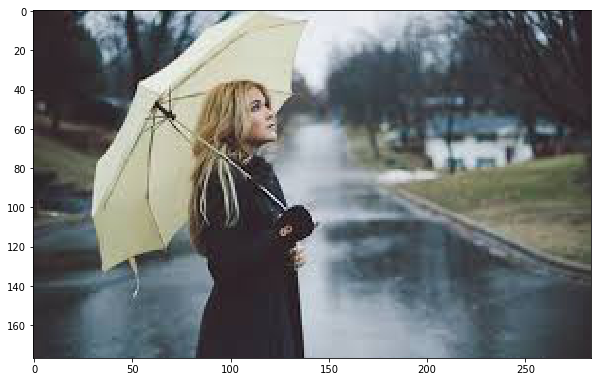

<start> a woman in a dress holding an umbrella . <end>


In [44]:
img_path = "/content/images.jpg"
im = Image.open(img_path)
im_list = np.asarray(im)
plt.figure(figsize=(10, 8))
plt.imshow(im_list)
plt.show()

# 実行
!python sample.py --image="/content/images.jpg"

# 【問題3】Kerasで動かしたい場合はどうするかを調査
PyTorchによる実装を動かしましたが、何らかの理由からKerasで動かしたい状況が考えられます。どういった手順を踏むことになるか調査し、できるだけ詳しく説明してください。

特に今回はPyTorchのための学習済みの重みをKerasで使えるようにしたいので、その点については必ず触れてください。

## MMdnnを利用する
MMdnnとは，Microsoft Researchにより開発が進められているオープンソースの深層学習モデルの変換と可視化を行うツール．Caffe、Keras、Tensorflow、CNTK、MXNet、PyTorch、CoreMLなどのフレームワークが相互運用可能になる．
## 使い方（簡単に）
* pip install mmdnnでインストールできる
* mmdownload -f keras -n inception_v3 -o ./          
といった具合に，学習済みの重みもダウンロードできる
>参考記事 : https://qiita.com/koppe/items/7f85f5411539390c4499

# 【問題4】（アドバンス課題）コードリーディングと書き換え
モデル部分はmodel.pyに書かれていますが、Kerasではこのモデルがどのように記述できるかを考え、コーディングしてください。その際機械翻訳のサンプルコードが参考になります。

# 【問題5】（アドバンス課題）発展的調査
《他の言語の翻訳を行う場合は？》

問題1の実装を使い日本語と英語の翻訳を行いたい場合はどのような手順を踏むか考えてみましょう。

### 《機械翻訳の発展的手法にはどのようなものがある？》

機械翻訳のための発展的手法にはどういったものがあるか調査してみましょう。

### 《文章から画像生成するには？》

イメージキャプショニングとは逆に文章から画像を生成する手法もあります。どういったものがあるか調査してみましょう。